In [26]:
# Imports, data, and paremters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.integrate import solve_ivp

# Excel file with parameters for easy review and modification
df_par = pd.read_excel('parameters/baseline_parameters.xlsx')

# Load PR8 (WT) virus data and genes
PR8 = pd.read_excel('data/Shapira_Ramos.xlsx', sheet_name='PR8')

# Get unique timepoints present in data to evaluate ODEs at
t_eval = PR8['Time'].unique().sort()

# List of states in the ODE system
state_labels = ['IFN','IFNe','STATP','IRF7','IRF7P','P','V']

# What timespan should the integration be performed over?
tspan = [0, 48]

### Initial Conditions for ODEs ###
y0 = np.zeros(len(state_labels))

# Initially 1 Cells, or a full (P)late of early-stage infected cells
# Find the index of the state label 'P' in the state_labels list
y0[state_labels.index('P')] = 1.0

# Initially 0.72205 IRF7
y0[state_labels.index('IRF7')] = 0.72205

# Initially 5 MOI Virus
y0[state_labels.index('V')] = 5

# Function definitions
def ODE_Model(t,y,p):

    # List of states in the ODE system
    states = ['IFN','IFNe','STATP','IRF7','IRF7P','P','V']

    # Create a dict from the states in s and values (y)
    s = dict(zip(states, y))
 
    dydt=[
        s['P']*(p['p_IFN_RIGI']*s['V']+(p['p_IFN_TLR']*s['V'])/(p['K_TLR_V']+s['V'])+p['p_IFN_IRF7P']*y[4])-p['p_IFNe_IFN']*s['IFN'],
        p['p_IFNe_IFN']*s['IFN']-p['d_IFNe']*s['IFNe'],
        (p['p_STATP_IFNe']*s['IFNe']*s['P'])/(p['K_IFNe_STATP']+s['IFNe'])-p['d_STATP']*s['STATP'],
        s['P']*(p['p_IRF7_STATP']*s['STATP']+p['p_IRF7_IRF7P']*s['IRF7P'])-p['d_IRF7']*s['IRF7'],
        p['p_IRF7P_IRF7']*s['IRF7']*s['P']-p['d_IRF7P']*s['IRF7P'],
        -p['d_P_V']*s['P']*s['V'],
        (p['p_V']*s['P']*s['V'])/(1+p['K_V_IFNe']*(s['IFNe']))-p['d_V']*s['V']      
    ]
    return dydt

#Measured species are reported in Log2 Fold Change (LFC)
def LFC(data,control):
    y=np.shape(data)[0]
    result=np.zeros(y)
    for i in range (0,y-1):
        result[i]=np.log2(data[i]/control)
    return result

# Data cleaning function. Takes ODEs and performs background and LFC to match data
def model_prep(sol):
    #Shift represents the background noise shift from RNA seq data
    shift = [7.939, 0, 12.2075, 13.4271, 0, 0, 0]

    #Control is the averaged control RNA seq data (with background noise)
    Control = [8.5684305, 13.24601, 15.767315]

    IFN=[]; IFNe=[]; STATP=[]; IRF7=[];
    IRF7P=[]; P=[]; V=[];

    #Assign species labels, add background noise shift, LFC
    IFN=sol.y[0,:]+shift[0];IFN=LFC(IFN,Control[0])
    IFNe=sol.y[1,:]
    STATP=sol.y[2,:]+shift[2];STATP=LFC(STATP,Control[1])
    IRF7=sol.y[3,:]+shift[3];IRF7=LFC(IRF7,Control[2])
    IRF7P=sol.y[4,:]
    P=sol.y[5,:]
    V=sol.y[6,:]

    model = [IFN,IFNe,STATP,IRF7,IRF7P,P,V]

    return model
  
#Solve the model
#Pack all ODE parameters into a dict
parameters = dict(zip(df_par.label, df_par.natinitval))

sol = solve_ivp(ODE_Model, tspan, y0, method='LSODA', t_eval=t_eval, vectorized=False, args=(parameters,))

Model has 7 states


Solution complete in 0.007435321807861328 seconds.


(<Figure size 640x480 with 9 Axes>,
 array([[<Axes: title={'center': 'IFN'}>,
         <Axes: title={'center': 'IFNe'}>,
         <Axes: title={'center': 'STATP'}>],
        [<Axes: title={'center': 'IRF7'}>,
         <Axes: title={'center': 'IRF7P'}>,
         <Axes: title={'center': 'Cells'}>],
        [<Axes: title={'center': 'Virus'}>, <Axes: >, <Axes: >]],
       dtype=object))

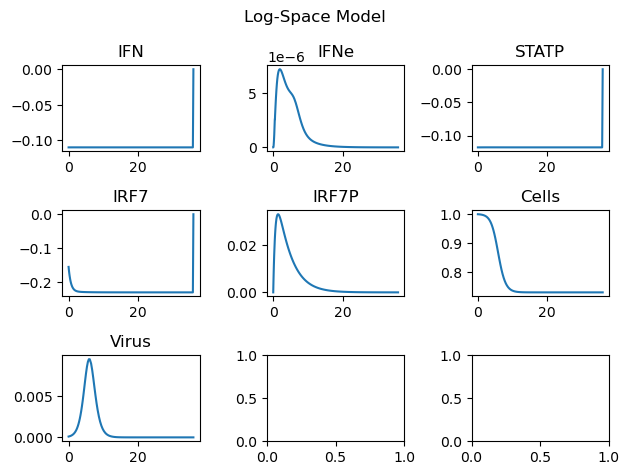

In [8]:
# Universal plotting function
def plot_model(model, t, title='Model'):
    #Plot the model
    fig, ax = plt.subplots(3,3)
    ax[0,0].plot(t,model[0]); ax[0,0].set_title('IFN')
    ax[0,1].plot(t,model[1]); ax[0,1].set_title('IFNe')
    ax[0,2].plot(t,model[2]); ax[0,2].set_title('STATP')
    ax[1,0].plot(t,model[3]); ax[1,0].set_title('IRF7')
    ax[1,1].plot(t,model[4]); ax[1,1].set_title('IRF7P')
    ax[1,2].plot(t,model[5]); ax[1,2].set_title('Cells')
    ax[2,0].plot(t,model[6]); ax[2,0].set_title('Virus')

    fig.suptitle(title)
    fig.tight_layout()
    return fig, ax

#Solve the model
#Pack all ODE parameters into a dict
parameters = dict(zip(df_par.label, df_par.natinitval))

start_time = time.time()
sol = solve_ivp(ODE_Model, tspan, y0, method='LSODA', t_eval=t_eval, vectorized=False, args=(parameters,))
end_time = time.time()
elapsed_time = end_time - start_time
print('Solution complete in', elapsed_time, 'seconds.')
data = model_prep(sol)
plot_model(data, sol.t, title='Log-Space Model')